<a href="https://colab.research.google.com/github/Viktorija29/Automaton/blob/master/SixTask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import torch
import os
import cv2
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet34
from google.colab import auth
from googleapiclient.discovery import build
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt



In [3]:
def download_data(file_id, file_name):
  import io
  from googleapiclient.http import MediaIoBaseDownload

  request = drive_service.files().get_media(fileId=file_id)
  downloaded = io.BytesIO()
  downloader = MediaIoBaseDownload(downloaded, request)
  done = False
  while done is False:
    _, done = downloader.next_chunk()
    
  downloaded.seek(0)
  with open(file_name, "wb") as f:
    f.write(downloaded.read())

  
auth.authenticate_user()
drive_service = build('drive', 'v3')

file_id = '1RyGeLi-mIgdxB01DYJbrgpKYGnkSOqgf'
file_name = 'animals.zip'

download_data(file_id, file_name)
!unzip animals.zip

Archive:  animals.zip
   creating: animals/elefante/
  inflating: animals/elefante/1.jpg  
  inflating: animals/elefante/10.jpg  
  inflating: animals/elefante/11.jpg  
  inflating: animals/elefante/12.jpg  
  inflating: animals/elefante/13.jpg  
  inflating: animals/elefante/14.jpg  
  inflating: animals/elefante/15.jpg  
  inflating: animals/elefante/16.jpg  
  inflating: animals/elefante/17.jpg  
  inflating: animals/elefante/18.jpg  
  inflating: animals/elefante/19.jpg  
  inflating: animals/elefante/2.jpg  
  inflating: animals/elefante/20.jpg  
  inflating: animals/elefante/3.jpg  
  inflating: animals/elefante/4.jpg  
  inflating: animals/elefante/5.jpg  
  inflating: animals/elefante/6.jpg  
  inflating: animals/elefante/7.jpg  
  inflating: animals/elefante/8.jpg  
  inflating: animals/elefante/9.jpg  
   creating: animals/farfalla/
  inflating: animals/farfalla/1.jpg  
  inflating: animals/farfalla/10.jpg  
  inflating: animals/farfalla/11.jpg  
  inflating: animals/farfalla

In [4]:
filenames = []
labels = []
for idx, class_dir in enumerate(os.listdir("animals")):
  print(f"берем файлы из папки \"{class_dir}\" и даем им класс {idx}")
  
  # не берем файлы кроме .jpg .jpeg и .png
  for file in os.listdir(os.path.join("animals", class_dir)):
    if not file.endswith(('.jpg', '.jpeg', '.png')):
      continue
      
    filenames.append(os.path.join("animals", class_dir, file))
    labels.append(idx)

берем файлы из папки "mucca" и даем им класс 0
берем файлы из папки "scoiattolo" и даем им класс 1
берем файлы из папки "farfalla" и даем им класс 2
берем файлы из папки "elefante" и даем им класс 3
берем файлы из папки "pecora" и даем им класс 4


2


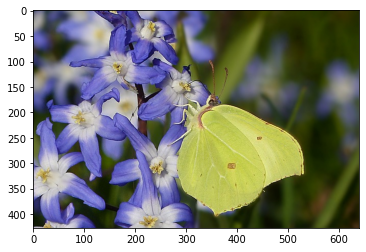

In [10]:
# будем брать по 1 рандомной картинке, выводить ее и смотреть на класс. Так в реально жизни можно проверить не *** ли вы скачали и верные ли классы
# можете выполнять этот cell пока не надоест
random_index = np.random.choice(range(len(filenames)))
test_img = cv2.imread(filenames[random_index])[:, :, ::-1] # эта штука в конце равносильно переводу из BGR в RGB
print(labels[random_index])
plt.imshow(test_img)

In [11]:
train_filenames, test_filenames, train_labels, test_labels = train_test_split(filenames, labels, test_size=0.3, random_state=42)

In [13]:
def add_pad(img, shape):
    color_pick = img[0][0]
    padded_img = color_pick * np.ones(shape + img.shape[2:3], dtype=np.uint8)
    x_offset = int((padded_img.shape[0] - img.shape[0]) / 2)
    y_offset = int((padded_img.shape[1] - img.shape[1]) / 2)
    padded_img[x_offset:x_offset + img.shape[0], y_offset:y_offset + img.shape[1]] = img
    return padded_img


def resize(img, shape):
    scale = min(shape[0] * 1.0 / img.shape[0], shape[1] * 1.0 / img.shape[1])
    if scale != 1:
        img = cv2.resize(img, dsize=None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
    return img